In [1]:
from pymilvus import (
    connections,
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection,
)

import time
import numpy as np
import json
import sys
import cv2
import torch
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import EncoderHeads, Dataset, Encoders, Preprocessors
device = 'cpu'

/Users/arjun/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Creating the vector database

In [17]:
with open("./msrvtt10000", "rb") as f:
    data = pickle.load(f)
    
resized_images = [cv2.resize(image, (299,299)) for image in data['images']]
data['resized_images'] = np.array(resized_images)

def get_image_head_inputs(images, image_model):
    batch_size = 128
    n = len(images)
    batches = n//batch_size
    
    image_encoder = Encoders.Encoder(image_model).to(device)
    image_preprocessor = Preprocessors.Preprocessor(image_model)
    
    image_head_inputs = torch.tensor([])
    
    for i in tqdm(range(batches+1)):
        image_batch = images[i*batch_size: (i+1)*batch_size]
        image_batch = torch.FloatTensor(np.array(image_batch)).to(device)
        image_batch = image_preprocessor.process(image_batch)
        image_batch_head_input = image_encoder(image_batch)
        
        image_head_inputs = torch.cat((image_head_inputs, image_batch_head_input), 0)
        
    return image_head_inputs

def get_text_head_inputs(texts, text_model):
    batch_size = 128
    n = len(texts)
    batches = n//batch_size
    
    text_encoder = Encoders.Encoder(text_model).to(device)
    text_preprocessor = Preprocessors.Preprocessor(text_model)
    
    text_head_inputs = torch.tensor([])
    
    for i in tqdm(range(batches+1)):
        text_batch = texts[i*batch_size: (i+1)*batch_size]
        text_batch, attention_batch = text_preprocessor.process(text_batch)
        text_batch_head_input = text_encoder(text_batch, attention_batch)
        
        text_head_inputs = torch.cat((text_head_inputs, text_batch_head_input), 0)
        
    return text_head_inputs

# Set hyperparameters, choose which models to use.
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "Xception"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"


image_head_inputs = get_image_head_inputs(data['resized_images'], image_encoder_model)

texts = []
video_maps_text = []
for i,_list in enumerate(data['texts']):
    video = data['video_id'][i]
    video_maps_text+= ([video]*len(_list))
    texts+=_list
video_maps_images = data['video_id']
video_maps = np.array(video_maps_images + video_maps_text)



text_head_inputs = get_text_head_inputs(texts, text_encoder_model)

image_head = EncoderHeads.EncoderHead(image_head_model, 2048, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model,768, embed_dim).to(device)
image_head.load_state_dict(torch.load('./image_head', map_location=torch.device('cpu')))
text_head.load_state_dict(torch.load('./text_head', map_location=torch.device('cpu')))

image_embeddings = image_head(image_head_inputs)
text_embeddings = text_head(text_head_inputs)

embeddings = torch.cat((image_embeddings,text_embeddings), 0).detach().numpy()

<All keys matched successfully>

In [96]:
def create_db(embeddings, labels):

    
    embeddings_shape = embeddings.shape

    id_to_label = dict(enumerate(list(set(labels))))
    label_to_id = dict(zip(id_to_label.values(),id_to_label.keys()))
    label_ids = [label_to_id[i] for i in labels]
    print("lenth of id_to_label: ", len(id_to_label))
    print("Embeddings shape",embeddings_shape)

    fmt = "\n=== {:30} ===\n"
    
    num_entities, dim = embeddings_shape

    #################################################################################
    # 1. connect to Milvus
    # Add a new connection alias `default` for Milvus server in `localhost:19530`
    # Actually the "default" alias is a buildin in PyMilvus.
    # If the address of Milvus is the same as `localhost:19530`, you can omit all
    # parameters and call the method as: `connections.connect()`.
    #
    # Note: the `using` parameter of the following methods is default to "default".
    print(fmt.format("start connecting to Milvus"))
    connections.connect("default", host="localhost", port="19530")

    has = utility.has_collection("video_search_db")
    print(f"Does collection video_search_db exist in Milvus: {has}")

    #################################################################################
    # 2. create collection
    fields = [
        FieldSchema(name="serial_no", dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="label", dtype=DataType.INT64),
        FieldSchema(name="embeddings", dtype=DataType.FLOAT_VECTOR, dim=dim)
    ]

    schema = CollectionSchema(fields, "DB for Reverse Video Search")

    print(fmt.format("Create collection `video_search_db`"))
    video_search_db = Collection("video_search_db", schema, consistency_level="Strong")

    ################################################################################
    # 3. insert data
    
    print(fmt.format("Start inserting entities"))
    
    batch_size = 2400
    n = len(embeddings)//batch_size
    
    for i in tqdm(range(n+1)):
        embeddings_batch = embeddings[i*batch_size: (i+1)*batch_size]
        label_ids_batch = label_ids[i*batch_size: (i+1)*batch_size]
    

        
        entities = [
            # provide the pk field because `auto_id` is set to False
            list(range(i*batch_size, i*batch_size + len(embeddings_batch))),
            label_ids_batch,  # field random, only supports list
            embeddings_batch,    # field embeddings, supports numpy.ndarray and list
        ]

        insert_result = video_search_db.insert(entities)

    print(f"Number of entities in Milvus: {video_search_db.num_entities}")  # check the num_entites

    ################################################################################
    # 4. create index
    # We are going to create an IVF_FLAT index for hello_milvus collection.
    # create_index() can only be applied to `FloatVector` and `BinaryVector` fields.
    print(fmt.format("Start Creating index IVF_FLAT"))
    index = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }

    video_search_db.create_index("embeddings", index)

    ################################################################################
    # 5. search, query, and hybrid search
    # After data were inserted into Milvus and indexed, you can perform:
    # - search based on vector similarity
    # - query based on scalar filtering(boolean, int, etc.)
    # - hybrid search based on vector similarity and scalar filtering.
    #

    # Before conducting a search or a query, you need to load the data in `hello_milvus` into memory.
    print(fmt.format("Start loading"))
    video_search_db.load()
    
    return video_search_db, fmt, id_to_label

In [77]:
def drop_db():
    # 7. drop collection
    # Finally, drop the hello_milvus collection
    #print(fmt.format("Drop collection `img_db`"))
    
    connections.connect("default", host="localhost", port="19530")
    utility.drop_collection("video_search_db")


In [78]:
#Create the database

drop_db() #delete it if it already exists
video_search_db, fmt, id_to_label = create_db(embeddings, video_maps)

lenth of id_to_label:  10000
Embeddings shape (209994, 256)

=== start connecting to Milvus     ===

Does collection video_search_db exist in Milvus: False

=== Create collection `video_search_db` ===


=== Start inserting entities       ===



  0%|          | 0/88 [00:00<?, ?it/s]

Number of entities in Milvus: 175200

=== Start Creating index IVF_FLAT  ===


=== Start loading                  ===



In [83]:
import matplotlib.pyplot as plt
def show_results(res_arr, query):
    
    fig, axs = plt.subplots(5,5, figsize=(25,25))
    for i,vid in enumerate(res_arr[:5]):

        cap = cv2.VideoCapture('./../filtered/{}.mp4'.format(vid))
        ret, frame = cap.read()
        counter=0
        j = 0
        while(ret):
            ret, frame = cap.read() 
            if counter%120==0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axs[i,j].imshow(frame)
                axs[i,j].axis('off')
                axs[i,j].set_title(vid)
                j+=1
            counter+=1
            if j==5:
                break
    print("Query:", query )
    plt.show()
        
def search(query, db, fmt, id_to_label, text_model=text_encoder_model, text_head=text_head):
    print(f"Number of entities in Milvus: {video_search_db.num_entities}")
    search_latency_fmt = "search latency = {:.4f}s"
    
    text_head_inputs = get_text_head_inputs([query], text_model)
    
    vectors_to_search = text_head(text_head_inputs).detach().numpy()


    # -----------------------------------------------------------------------------
    # search based on vector similarity
    print(fmt.format("Start searching based on vector similarity"))


    search_params = {
        "metric_type": "L2",
        "params": {"nprobe": 10},
    }

    #print(vectors_to_search.shape)
    start_time = time.time()
    result = db.search(vectors_to_search, "embeddings", search_params, limit=100, output_fields=["label", "serial_no"])
    end_time = time.time()

    res_labels = []
    res_arr = []
    last_embedding = None
    counter=0
    for hits in result:
        for hit in hits:
            res_labels.append(hit.entity.get('label'))
            res_arr.append(id_to_label[hit.entity.get('label')])
            l = id_to_label[hit.entity.get('label')]
            
            #print(f"hit: {hit}, label: {id_to_label[hit.entity.get('label')]}")
            if counter==20:
                break

    print(search_latency_fmt.format(end_time - start_time))
    #res_labels = pd.Series(res_labels).value_counts()
    res_labels = pd.Series(res_labels).apply(lambda a: id_to_label[a]).drop_duplicates()
    show_results(list(res_labels), query)
    
    return res_labels

# Query the database

Number of entities in Milvus: 208800


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]


=== Start searching based on vector similarity ===

search latency = 0.6323s
Query: kids playing outside


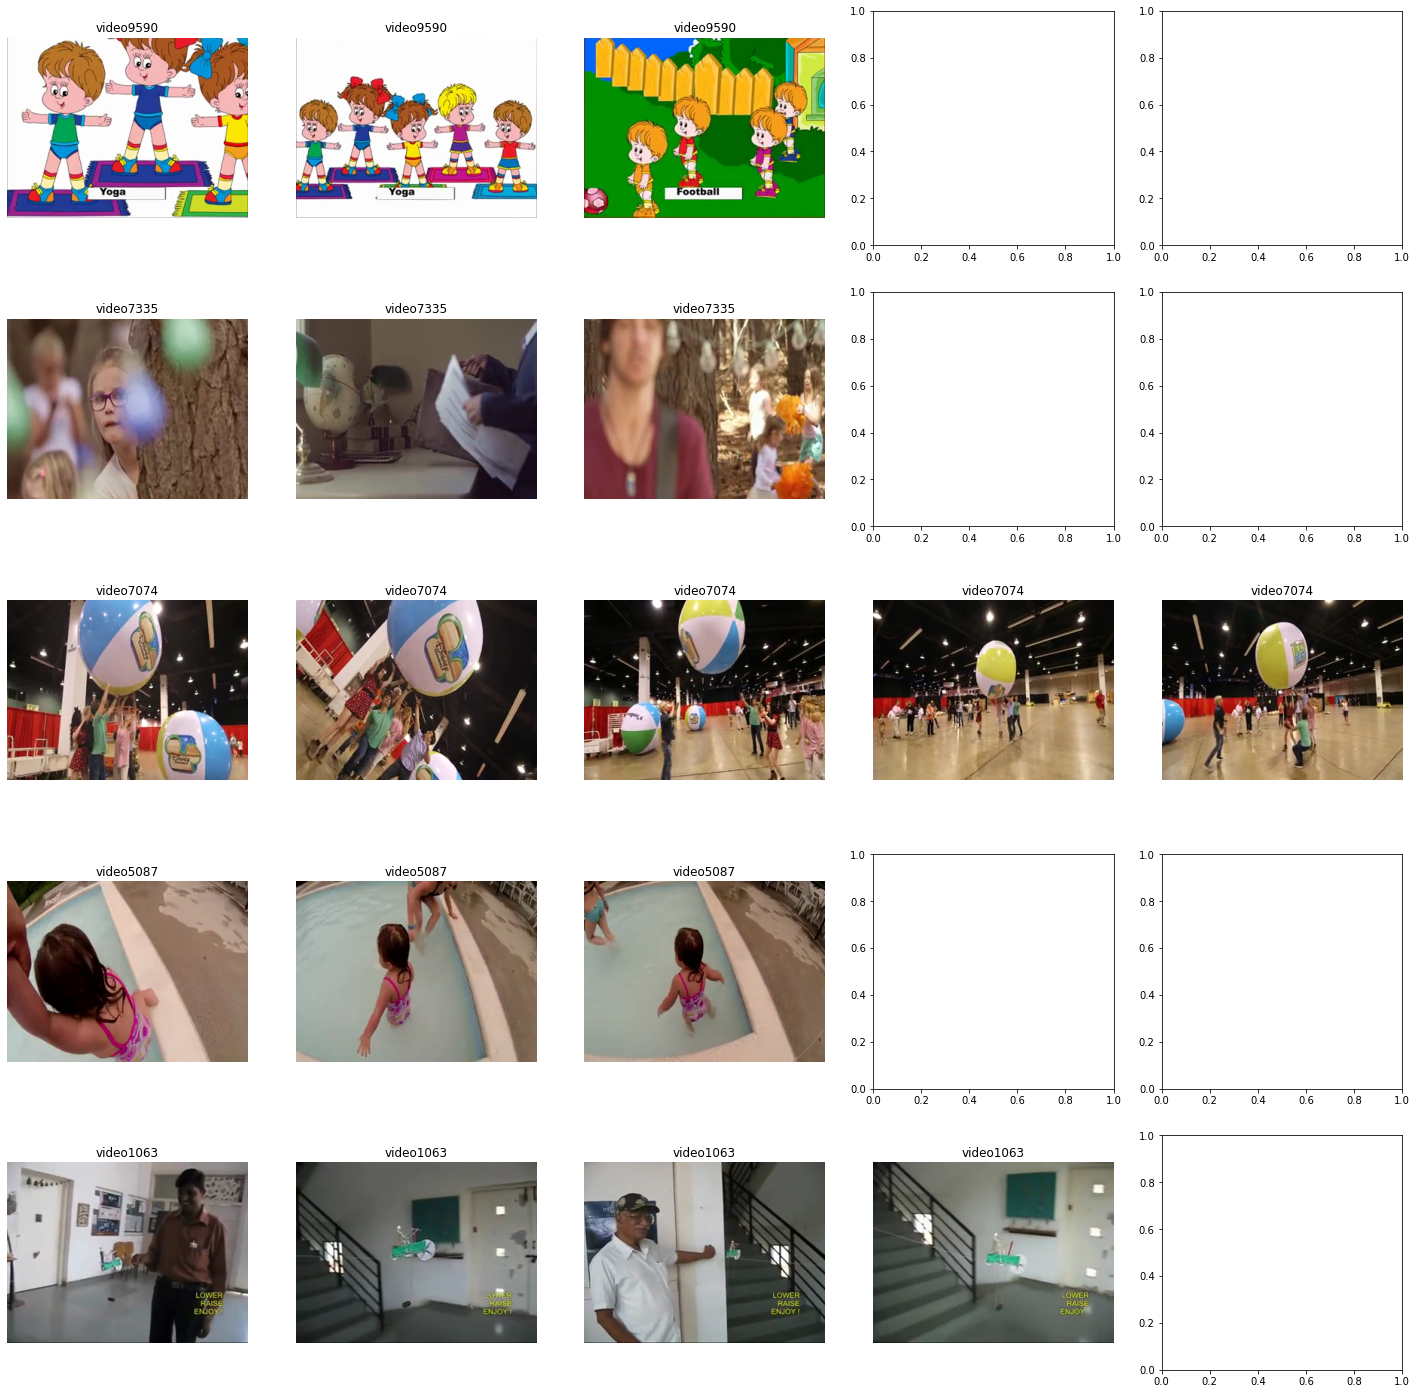

In [95]:
res_arr = search('kids playing outside',video_search_db, fmt, id_to_label)